In [1]:
# load dogs vs cats dataset, reshape and save to a new file
from zipfile import ZipFile 
import os
from google.colab import drive
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
def loadData(file_name):
  imgs=[]
  files=[]
  labels=[]  

  # opening the zip file in READ mode 
  with ZipFile(file_name, 'r') as zip:
    fileList=zip.namelist() # get list of filename in zip file
    i=0
    for file in fileList:
      if not file.endswith('/'):
        with zip.open(file) as myfile: # open file from zip
          if i%3==0: # this use if limited in your memory
            # load image
            photo=Image.open(myfile)
            # convert to numpy array and store
            imgs.append(img_to_array(photo.resize((128,128))))
            files.append(file.split('/')[2])
            if 'cat' in file:
              labels.append(0)
            else:
              labels.append(1)
          i+=1
  # convert to a numpy arrays
  imgs = np.asarray(imgs)
  labels = np.asarray(labels)
  print('Shape of images and labels = (',imgs.shape, labels.shape, ')')

  return imgs, labels, files

  # define cnn model 
def define_model1(input_shape):
  model = Sequential()
  model.add(Flatten(input_shape=input_shape))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

# define cnn model (VGG 3layer)
def define_model2(input_shape):
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.5))
	model.add(Dense(2, activation='softmax'))
	# compile model
	model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
	return model

In [3]:
def generateData(xData, yData, batch_size=32):
	x_train, x_valid, y_train, y_valid = train_test_split(xData, yData, test_size=0.2, random_state=1)
	del xData, yData
  # create data generator
  # datagen_train = ImageDataGenerator(rescale=1.0/255.0,
	#                             # height_shift_range=0.5,
	# 														# rotation_range=30,
  #                             # horizontal_flip=True,
  #                             # zoom_range=[0.5,1.0],
  #                             brightness_range=[0.2,1.0])
	datagen_valid = ImageDataGenerator(rescale=1.0/255.0)
	datagen_train = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = datagen_train.flow(x_train, y_train, batch_size=batch_size)
	valid_it = datagen_valid.flow(x_valid, y_valid, batch_size=batch_size)
#	test_it = datagen_valid.flow(x_test, y_test, batch_size=64)
	return train_it, valid_it

# run the test harness for evaluating a model
def process(train_it, valid_it, input_shape, batch_size=32, epoch=20):
  # use GPU and test GPU found if you don't have GPU please comment
  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
  print('Found GPU at: {}'.format(device_name))

  # define model
  # model = define_model1(input_shape)
  model = define_model2(input_shape)
  # fit model
  history = model.fit(train_it, steps_per_epoch=len(train_it)//batch_size,
                      validation_data=valid_it, validation_steps=len(valid_it)//batch_size, epochs=epoch)
  # save model
  model.save('final_model.h5')
  return model,history

# plot diagnostic learning curves
def summarize_diagnostics(history,path):
  # plot loss
  plt.figure(figsize=(6,10))
  plt.subplot(211)
  plt.title('Cross Entropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='validation')
	# plot accuracy
  plt.subplot(212)
  plt.title('Classification Accuracy')
  plt.plot(history.history['accuracy'], color='blue', label='train')
  plt.plot(history.history['val_accuracy'], color='orange', label='validation')
  # save plot to file
  filename = os.path.join(path,'summary_plot.png')
  print(filename)
  plt.savefig(filename)
  plt.show()
  plt.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape of images and labels = ( (7500, 128, 128, 3) (7500,) )
1 dog.2501.jpg


<function matplotlib.pyplot.show>

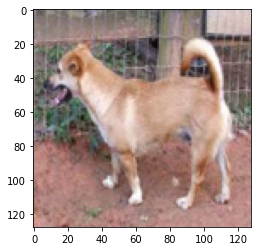

In [4]:
from keras.preprocessing.image import array_to_img
# main
# mount drive in google drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks/DeepLearningTool/DogCatClassification/") # change directory
path=os.getcwd() #read current directory

# specifying the zip file name 
file_name = os.path.join(path,'dataDogCat/train.zip')
xData, yData, fileName=loadData(file_name)

# use this to show the image
print(yData[5000],fileName[5000])
plt.imshow(array_to_img(xData[5000]))
plt.show

In [5]:
%matplotlib inline
# generate Data
batch_size=32
# One hot categories of label for multiple classes
yLabel=tf.keras.utils.to_categorical(yData, num_classes=2)
print(yLabel[0])

train_it, valid_it=generateData(xData,yLabel,batch_size)

[1. 0.]


In [6]:
# entry point, run the test harness
input_shape=(128, 128, 3)
epoch=100
model, history=process(train_it, valid_it, input_shape, batch_size,epoch)
model.summary()

Found GPU at: /device:GPU:0
Epoch 1/100
5/5 [==============================] - 3s 109ms/step - loss: 37.9701 - accuracy: 0.5375 - val_loss: 1.3480 - val_accuracy: 0.5625
Epoch 2/100
5/5 [==============================] - 0s 61ms/step - loss: 2.7423 - accuracy: 0.5500 - val_loss: 0.6570 - val_accuracy: 0.5938
Epoch 3/100
5/5 [==============================] - 0s 55ms/step - loss: 0.8817 - accuracy: 0.5625 - val_loss: 0.6965 - val_accuracy: 0.5312
Epoch 4/100
5/5 [==============================] - 0s 60ms/step - loss: 0.7741 - accuracy: 0.5063 - val_loss: 0.6941 - val_accuracy: 0.5625
Epoch 5/100
5/5 [==============================] - 0s 57ms/step - loss: 0.7290 - accuracy: 0.4812 - val_loss: 0.6936 - val_accuracy: 0.4688
Epoch 6/100
5/5 [==============================] - 0s 59ms/step - loss: 0.7063 - accuracy: 0.5437 - val_loss: 0.6938 - val_accuracy: 0.5625
Epoch 7/100
5/5 [==============================] - 0s 55ms/step - loss: 0.7042 - accuracy: 0.4875 - val_loss: 0.6918 - val_accurac

1/1 [==============================] - 0s 64ms/step - loss: 0.6301 - accuracy: 0.6875
> 68.750
/content/drive/My Drive/Colab Notebooks/DeepLearningTool/DogCatClassification/summary_plot.png


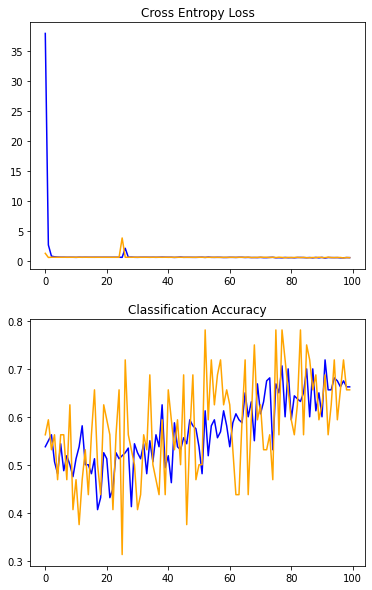

In [7]:
# evaluate model
_, acc = model.evaluate(valid_it, steps=len(valid_it)//batch_size)
#_, acc = model.evaluate(valid_it, verbose=2)
print('> %.3f' % (acc * 100.0))
# learning curves
summarize_diagnostics(history,path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[[0.4711283 0.5288717]] 1 cat.10009.jpg
[[0.48567584 0.5143242 ]] 1 cat.11024.jpg
[[0.56021214 0.43978786]] 0 cat.12309.jpg
[[0.530342   0.46965802]] 0 cat.2094.jpg
[[0.70663667 0.29336336]] 0 cat.3263.jpg
[[0.64942545 0.35057452]] 0 cat.433.jpg
[[0.5574119  0.44258806]] 0 cat.5441.jpg
[[0.5085766 0.4914235]] 0 cat.6479.jpg
[[0.55368763 0.44631234]] 0 cat.7613.jpg
[[0.44771528 0.5522847 ]] 1 cat.8859.jpg
[[0.40306515 0.5969349 ]] 1 dog.10002.jpg
[[0.3987991  0.60120094]] 1 dog.1109.jpg
[[0.2711604  0.72883964]] 1 dog.12137.jpg
[[0.62321347 0.37678656]] 0 dog.2116.jpg
[[0.40852296 0.59147704]] 1 dog.3257.jpg
[[0.72204393 0.27795604]] 0 dog.4513.jpg
[[0.5497033 0.4502967]] 0 dog.5661.jpg
[[0.44284064 0.55715936]] 1 dog.6714.jpg
[[0.41304332 0.5869567 ]] 1 dog.7683.jpg
[[0.4375252 0.5624748]] 1 dog.8839.jpg


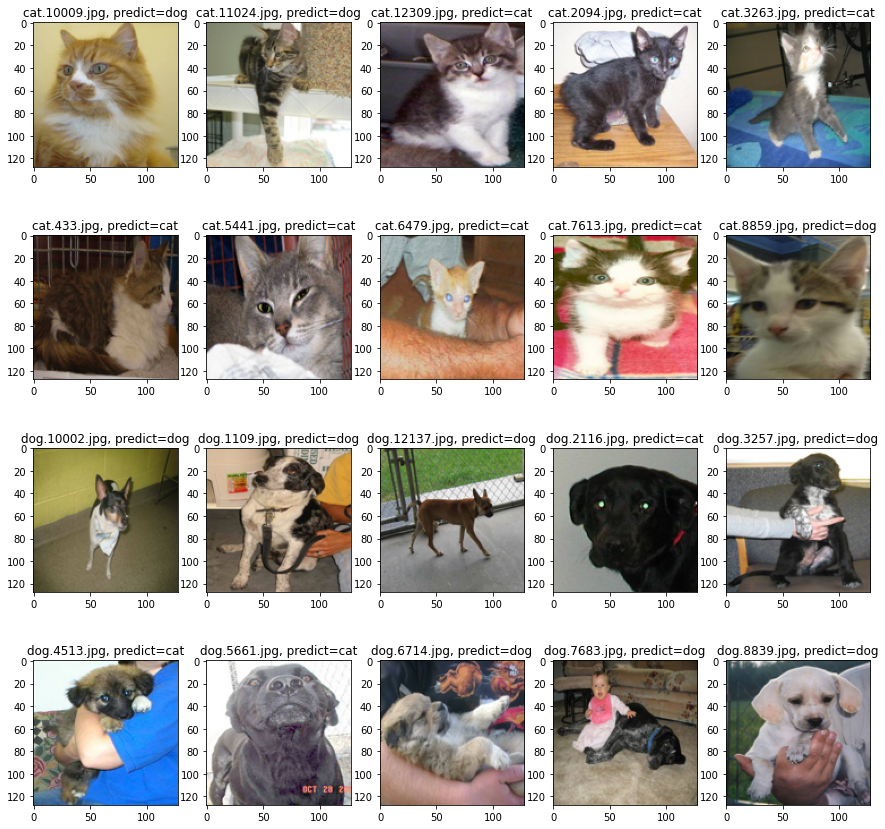

In [8]:
from tensorflow.keras.models import load_model
# LoadData for Testing
def loadTestData(file_name):
  imgs=[]
  files=[]
  labels=[]
  # opening the zip file in READ mode
  i=0 
  with ZipFile(file_name, 'r') as zip:
    fileList=zip.namelist() # get list of filename in zip file
    for file in fileList:
      if not file.endswith('/'):
        with zip.open(file) as myfile: # open file from zip
          if i%125==0:
            # load image, convert to numpy array and store
            imgs.append(Image.open(myfile).resize((128,128)))
            files.append(file.split('/')[2])
            if 'cat' in file:
              labels.append(0)
            else:
              labels.append(1)
          i+=1

  return imgs, labels, files

drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks/DeepLearningTool/DogCatClassification/") # change directory
path=os.getcwd() #read current directory

# specifying the zip file name and load test data
file_name = os.path.join(path,'dataDogCat/test.zip')
xTest, yTest, dFile = loadTestData(file_name)
# load model
model=load_model('final_model.h5')

# read data
for i in range(0,20):
  # predict the class
  image=img_to_array(xTest[i])
  # if i==1 : 
  #   print(image.shape)
  # expand dimension for the same input of model at axis 0 (row dimension)
  image=np.expand_dims(np.array(image), 0)
  # predict the image (image should be devide by 255.0 to be prob)
  result = model.predict(image/255.0)
#  y_true = np.argmax(yTest[i]) # use for check accuracy
  y_pr = np.argmax(result[0])
  print(result,y_pr,dFile[i])
  if y_pr==0:
    out='cat'
  else:
    out='dog'
	# define subplot
  plt.figure(1,figsize=(15,15))
  plt.subplot(4,5,i+1)
  # plot raw pixel data
  plt.imshow(xTest[i])
  plt.title(dFile[i]+', predict='+out)

# show the figure
plt.show()

In [9]:
dc=2500/200